In [2]:
from import_data import *
from constants import *
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

# set up parameters based on A4 paper
plt.rcParams.update({
    "savefig.dpi": 300,
    "font.size": 10,  # Font size for text (like in the report)
    # "axes.labelsize": 8,  # Font size for x-axis labels
})

In [3]:
# helper function
def fig_size(x_ratio=1.0, y_ratio=1.0):
    """
    Assuming an A4 paper size, this function returns a tuple
    representing the figure size in inches.
    parameters:
    x_ratio: float, ratio of the width relative to A4 width
    y_ratio: float, ratio of the height relative to A4 height
    """
    A4_WIDTH = 6.202  # A4 paper text width in inches
    A4_HEIGHT = 9.3562  # A4 paper text height in inches
    if x_ratio <= 0 or y_ratio <= 0:
        raise ValueError("Ratios must be positive numbers.")
    return (A4_WIDTH * x_ratio, A4_HEIGHT * y_ratio)


## Data exploration

In [7]:
# Prepare the data
df_train_grouped = df_train.groupby('engine')
df_train_last_cycle = df_train_grouped.max()['cycle']
df_train_with_labels = df_train.copy()
df_train_with_labels['RUL'] = df_train_with_labels.apply(lambda row: df_train_last_cycle[row['engine']] - row['cycle'], axis=1)
# df_train_with_labels.drop(index=df_train_with_labels[df_train_with_labels['RUL'] < 1].index, inplace=True)

# Now the DataFrame df_train_with_labels contains the RUL for each row
print(df_train_with_labels.columns)
# Cap RUL to 125
df_train_with_labels['RUL'] = df_train_with_labels['RUL'].clip(upper=125)
test_labels = pd.read_csv(fr"Data\RUL_{DATASET_NAME}.txt", header=None)
test_labels = test_labels.clip(upper=125)


Index(['engine', 'cycle', 'altitude', 'mach_nr', 'TRA', 'T2', 'T24', 'T30',
       'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf',
       'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32',
       'RUL'],
      dtype='object')


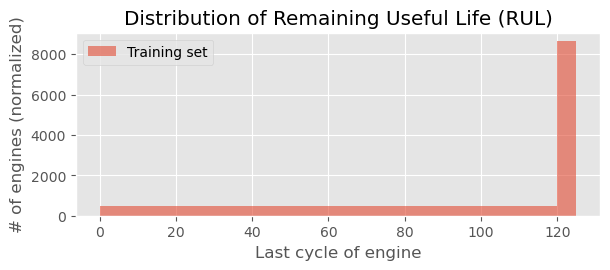

In [8]:
# First group by the engine(id) and find the last cycle
fig, ax = plt.subplots(1, 1, figsize=fig_size(1, 0.3))
ax.hist(df_train_with_labels.RUL, histtype="stepfilled", label="Training set", bins=25, alpha=0.6, zorder=2, density=False)

ax.set_xlabel("Last cycle of engine")
ax.set_ylabel("# of engines (normalized)")
ax.set_title("Distribution of Remaining Useful Life (RUL)")

plt.legend()
plt.tight_layout()
plt.show()

21 sensors found in the data


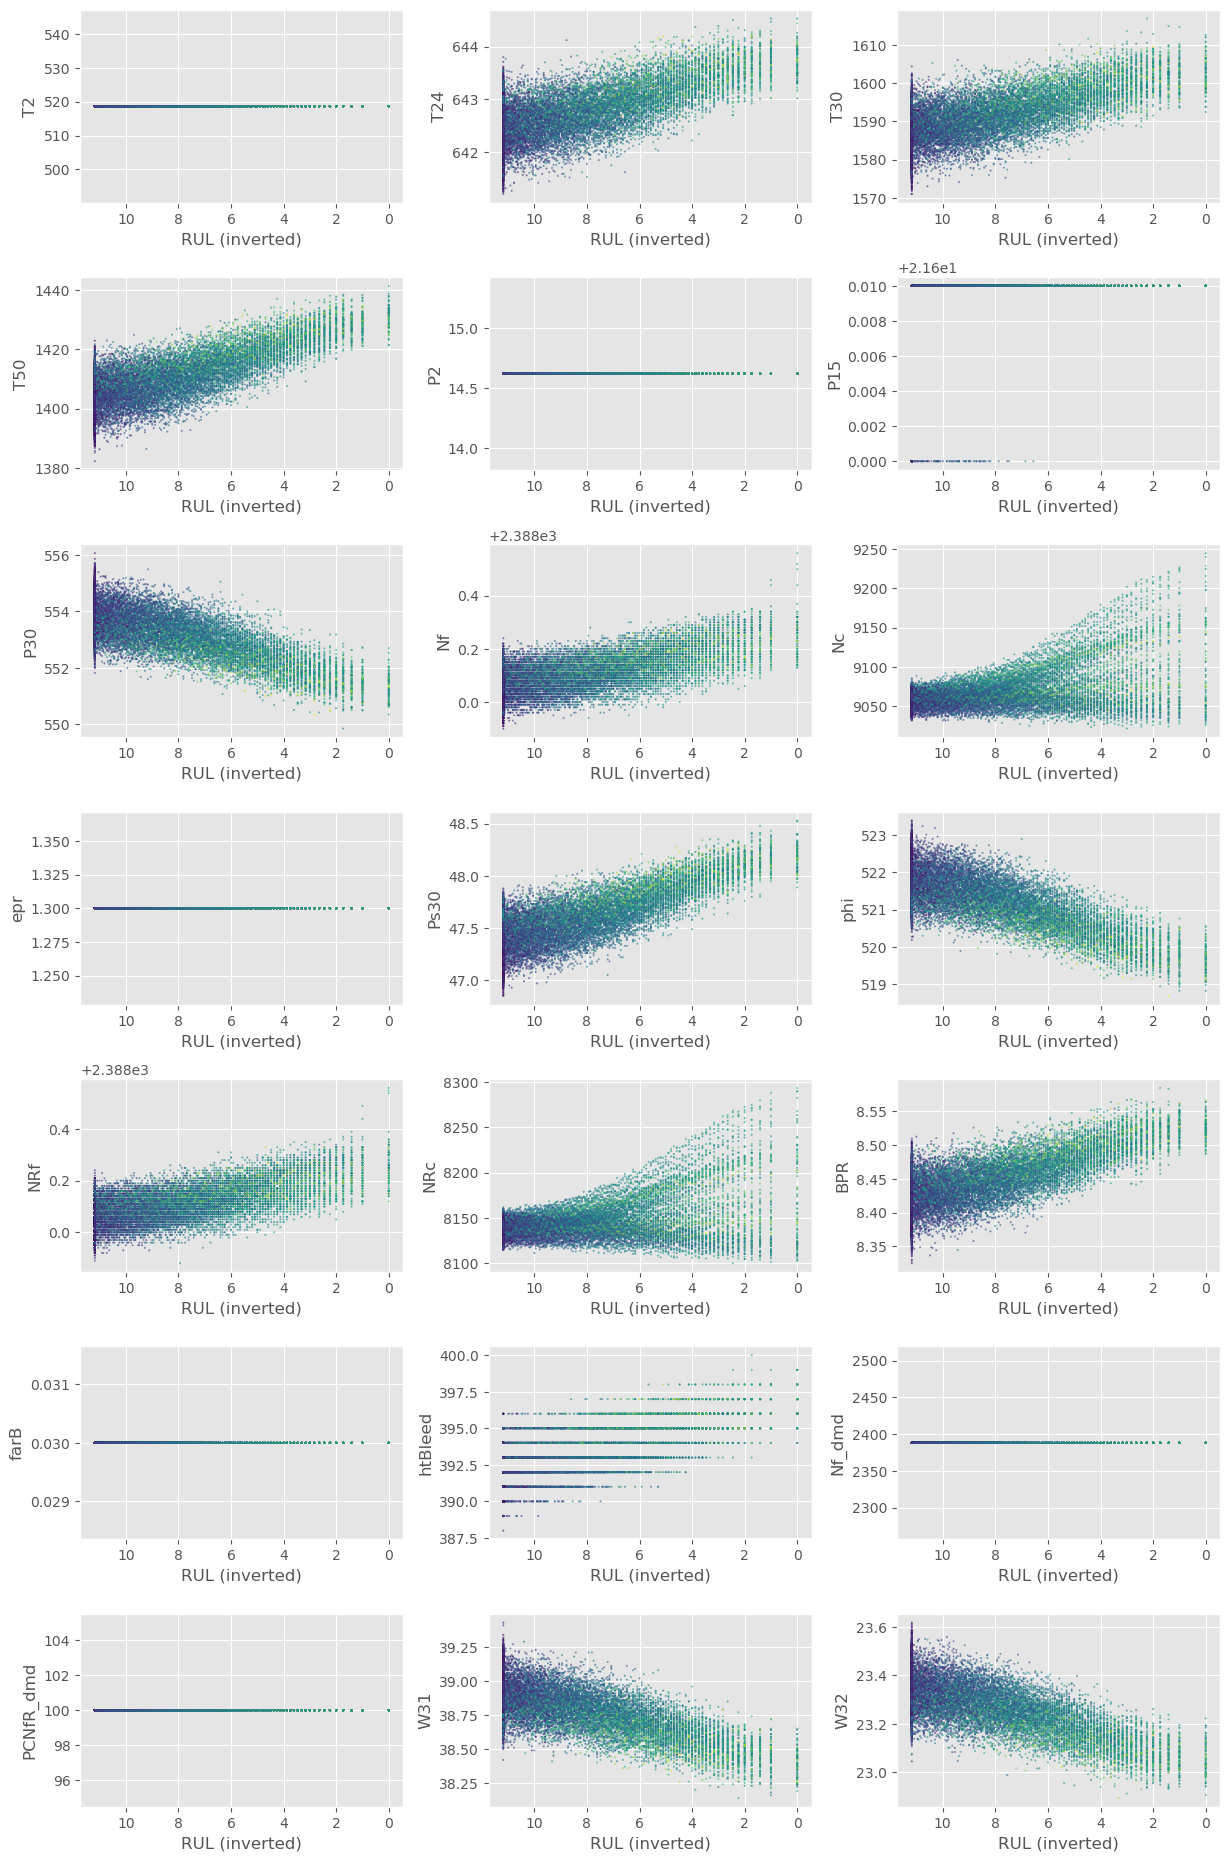

In [ ]:
# plot all sensor measurements against the RUL
sensor_columns = df_train_with_labels.columns[5:-1]  # Exclude 'engine', 'cycle', and 'RUL'
print(len(sensor_columns), "sensors found in the data") # ==> 21 sensors found in the data
fig,axs = plt.subplots(7, 3, figsize=fig_size(2, 2))
axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration
for i, sensor in enumerate(sensor_columns):
    ax = axs[i]
    ax.xaxis.set_inverted(True)  
    ax.scatter(df_train_with_labels.RUL , df_train_with_labels[sensor], alpha=0.5, s=1, c=df_train_with_labels.cycle)
    ax.set_xlabel("RUL (inverted)")
    ax.set_ylabel(sensor)
    # ax.set_title(f"Sensor: {sensor}", )
plt.tight_layout()
plt.show()

Uncorrelated sensors: ['T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']
Sensors of interest: ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']


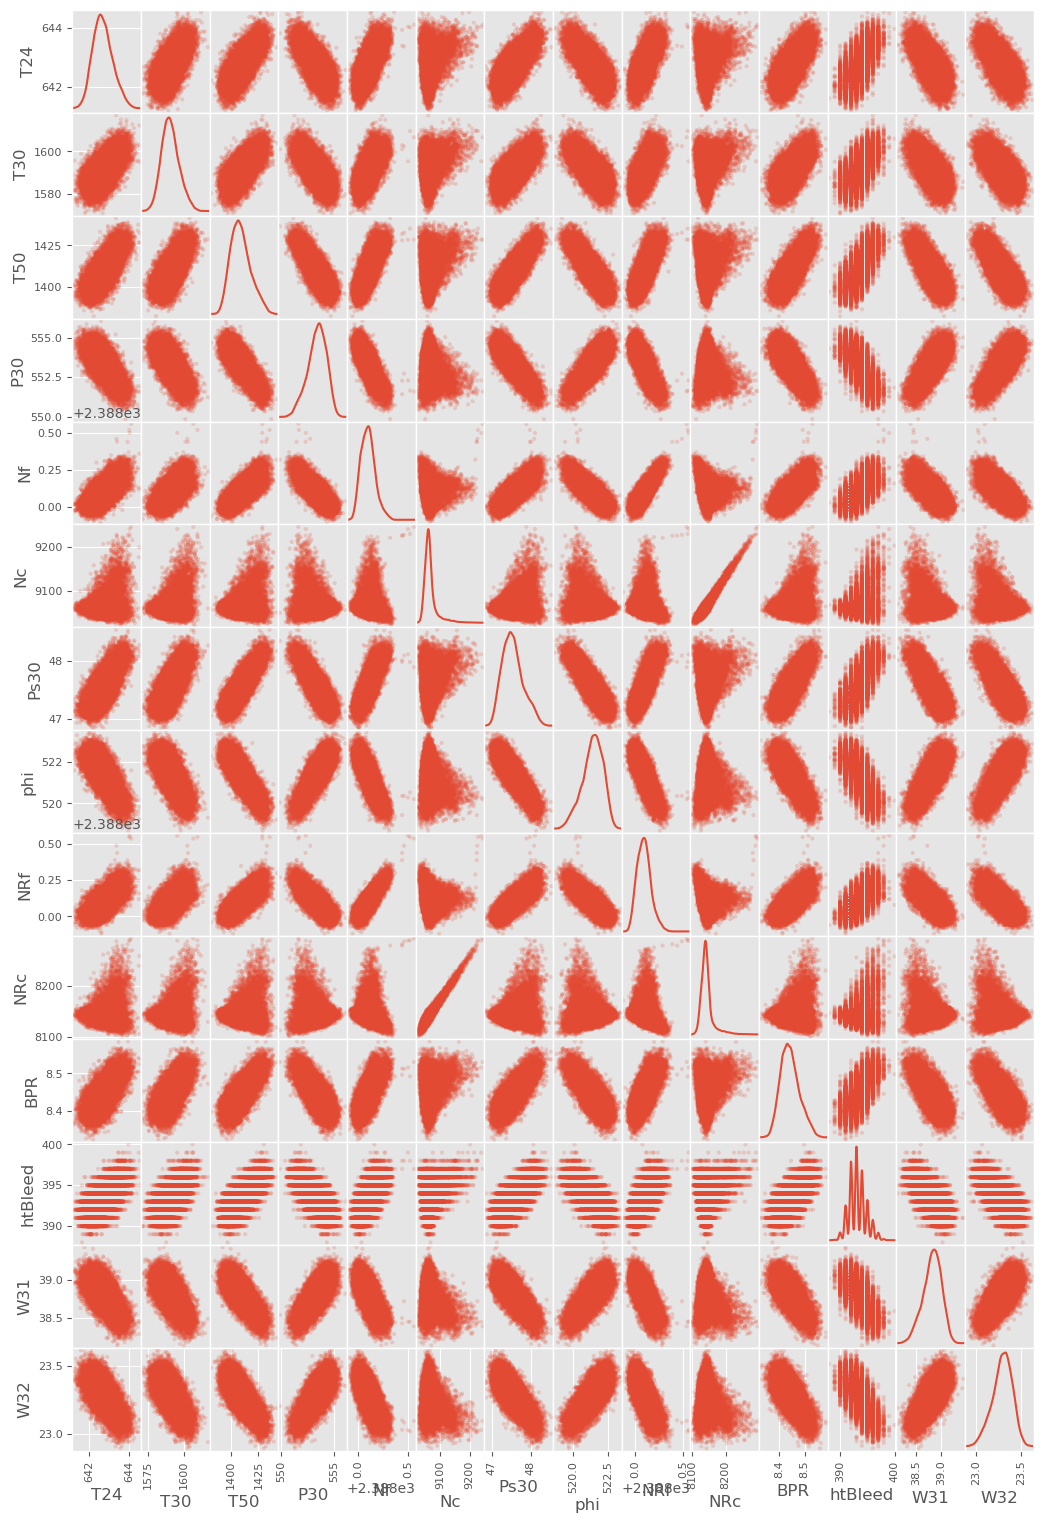

In [6]:
# Selecting the uncorrelated sensors
uncorrelated_sensors = ["T2","P2", "P15", "epr", "farB", "Nf_dmd", "PCNfR_dmd"]
print("Uncorrelated sensors:", uncorrelated_sensors)

sensors_of_interest = [sens for sens in sensor_columns if sens not in uncorrelated_sensors]
print("Sensors of interest:", sensors_of_interest)

pd.plotting.scatter_matrix(df_train_with_labels[sensors_of_interest], alpha=0.2, figsize=fig_size(2, 2), diagonal='kde')
plt.show()

14 sensors of interest found in the data


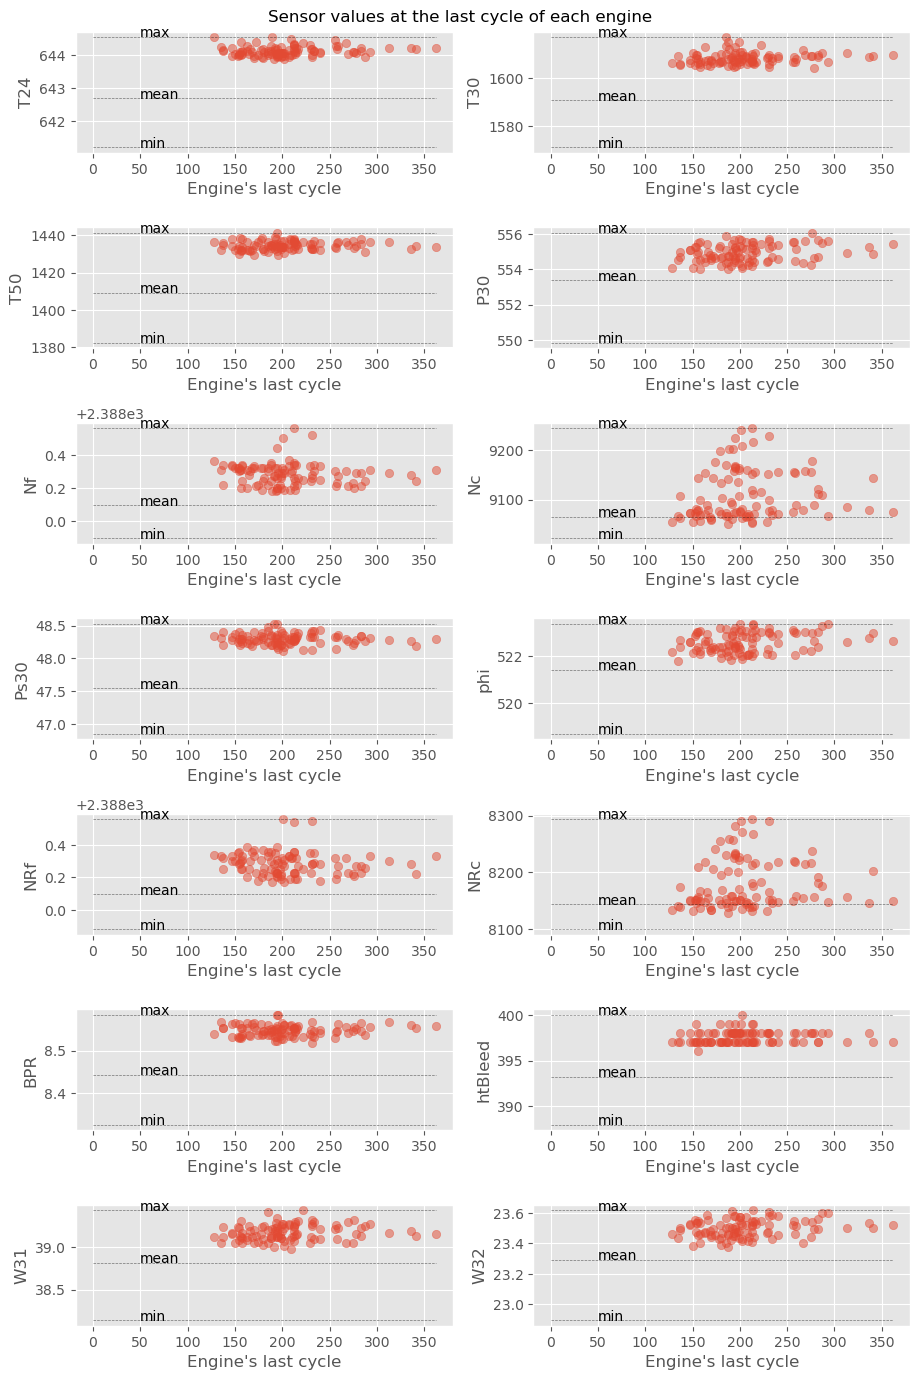

In [7]:
# the value of the sensors at the last cycle of each engine
print(len(sensors_of_interest), "sensors of interest found in the data")  # ==> 14 sensors of interest found in the data
fig, axs = plt.subplots(7, 2, figsize=fig_size(1.5, 1.5))
axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration
for i, sensor in enumerate(sensors_of_interest):
    ax = axs[i]
    ax.hlines(y=[df_train.max()[sensor], df_train.min()[sensor], df_train.mean()[sensor]], xmin=0, xmax=df_train_last_cycle.max(), color='black', alpha=0.5, ls='--', lw=0.5)
    ax.text(50,df_train.max()[sensor], "max")
    ax.text(50,df_train.min()[sensor], "min")
    ax.text(50,df_train.mean()[sensor], "mean")
    ax.scatter(df_train_last_cycle, df_train_grouped.max()[sensor], alpha=0.5,)
    ax.set_xlabel("Engine's last cycle")
    ax.set_ylabel(sensor)
    # ax.set_title(f"Sensor: {sensor}", fontsize=8)
fig.suptitle("Sensor values at the last cycle of each engine")
plt.tight_layout()
plt.show()

### Prognosability of the data
$$\exp (\frac{-\text{std} \ {\text{sens}_{EoL}}}{\text{mean}(|\text{sens}_{0} - \text{sens}_{EoL}|)})$$
Where $\text{sens}_{EoL}$ is the sensor value at the end of life, $\text{sens}_{0}$ is the sensor value at the beginning of life, and std is the standard deviation.

$$\mathcal{P}^j = \exp \left[ \frac{-\text{STD}(\mathcal{L}^{e,j}_F, e \in E)}{\left| \frac{1}{|E|} \sum_{e \in E} |\mathcal{L}^{e,j}_1 - \mathcal{L}^{e,j}_F| \right|} \right]$$

In [8]:
# Prognosability
num_engines = len(df_train_grouped)
prognosability = {}
# print("Number of engines in the training set:", num_engines)  # ==> 100 engines in the training set

for i, sensor in enumerate(sensors_of_interest):
    sens_0 = df_train_grouped[sensor].first()
    sens_last = df_train_grouped[sensor].last()
    
    sens_last_std = sens_last.std()
    mean_range = (sens_0 - sens_last).abs().mean()  
    
    prognosability[sensor] = np.exp(-sens_last_std / mean_range)

prognosability
    

{'T24': np.float64(0.8047952326960797),
 'T30': np.float64(0.7623775199581817),
 'T50': np.float64(0.8709352510332526),
 'P30': np.float64(0.8380953120907355),
 'Nf': np.float64(0.6542652206199866),
 'Nc': np.float64(0.3249736027768811),
 'Ps30': np.float64(0.8670547490313948),
 'phi': np.float64(0.8465543844872512),
 'NRf': np.float64(0.663019097029578),
 'NRc': np.float64(0.310641530005493),
 'BPR': np.float64(0.8418661086829425),
 'htBleed': np.float64(0.7928640249050138),
 'W31': np.float64(0.8289448316462193),
 'W32': np.float64(0.8091408159593789)}

### Monotonicity

In [9]:
sensors_of_interest

['T24',
 'T30',
 'T50',
 'P30',
 'Nf',
 'Nc',
 'Ps30',
 'phi',
 'NRf',
 'NRc',
 'BPR',
 'htBleed',
 'W31',
 'W32']

In [10]:
### monotonicity

def I(x):
    """
    Indicator function that returns 1 if x is greater than 0, otherwise returns 0.
    """
    return np.where(x > 0, 1, 0)

def monotonicity_check(sensor_values):
    h_fp1 = sensor_values[1:].to_numpy()
    h_f = sensor_values[:-1].to_numpy()
    _monotonicity = np.abs((I(h_fp1 - h_f)-I(h_f-h_fp1)).sum())/(len(sensor_values)-1)
    return _monotonicity
monotonicity = {}

for engine in df_train_last_cycle.index:
    monotonicity[engine] = {}
    for sensor in sensors_of_interest:
        monotonicity[engine][sensor] = monotonicity_check(df_train_with_labels[df_train_with_labels['engine'] == engine][sensor]) 

monotonicity_df = pd.DataFrame(monotonicity).T
monotonicity_df.mean()

T24        0.036342
T30        0.033481
T50        0.035526
P30        0.044567
Nf         0.034419
Nc         0.045034
Ps30       0.038022
phi        0.036842
NRf        0.029607
NRc        0.052409
BPR        0.038052
htBleed    0.022356
W31        0.034326
W32        0.036175
dtype: float64

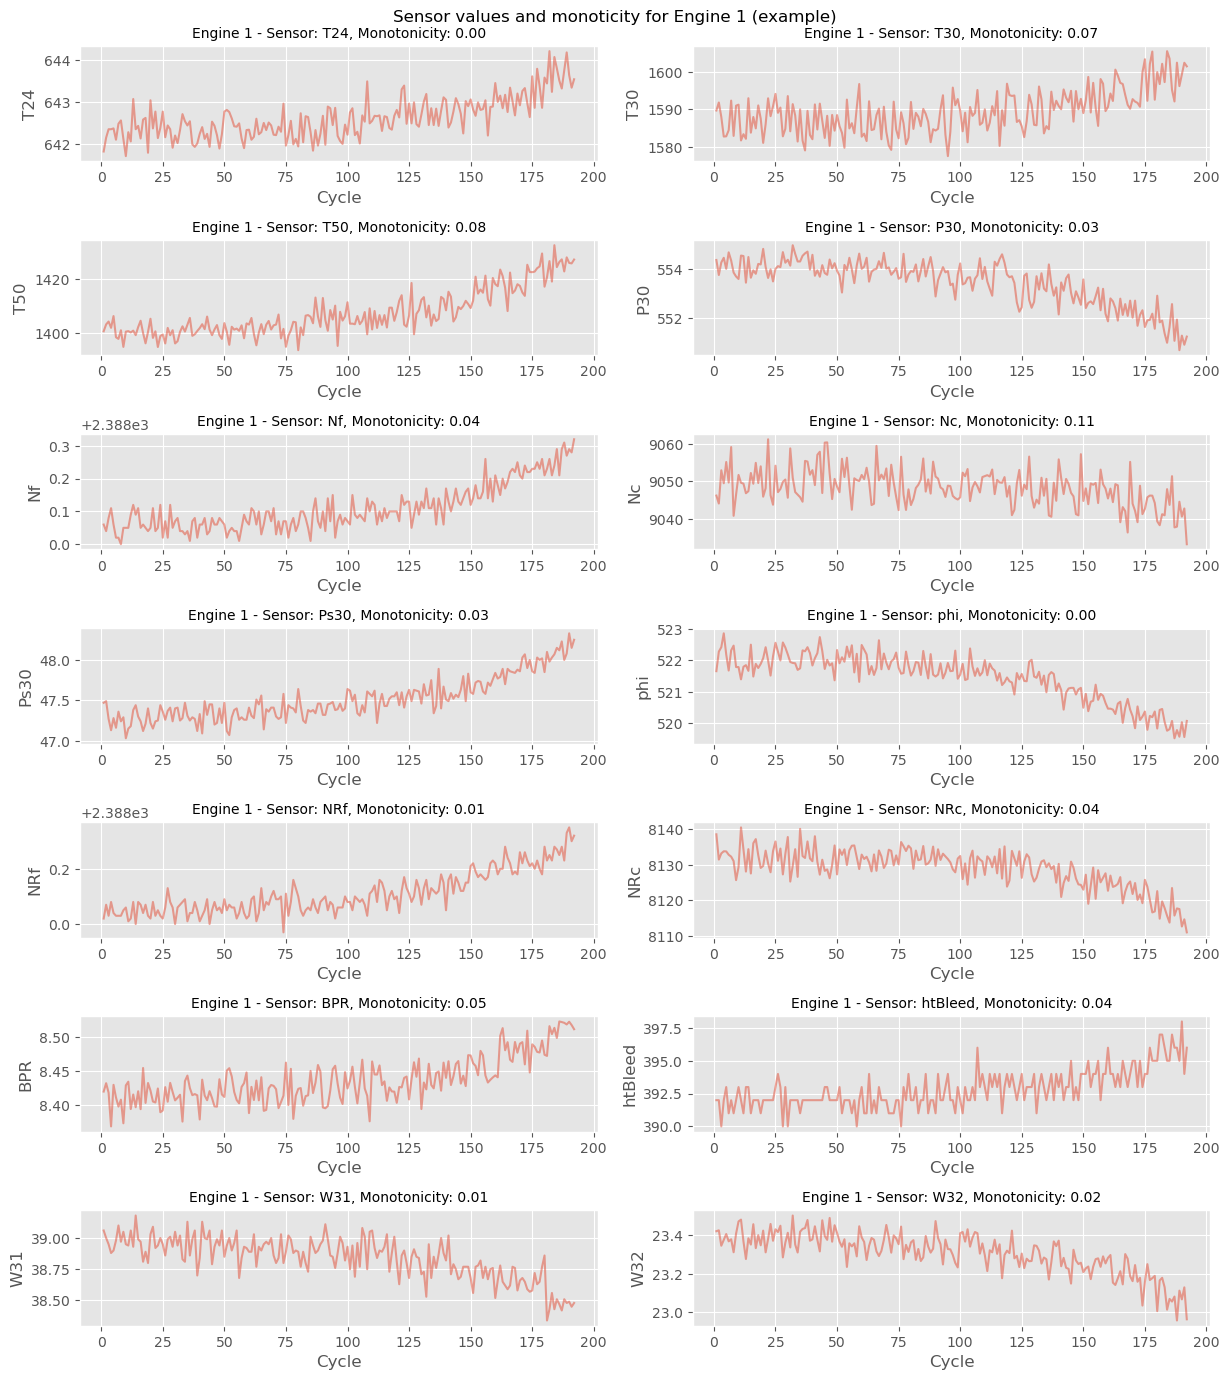

In [11]:
fig, axs = plt.subplots(7, 2, figsize=fig_size(2, 1.5))
axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration
_engine_number = 1
for i, sensor in enumerate(sensors_of_interest):
    ax = axs[i]
    ax.plot(df_train.loc[df_train['engine'] == _engine_number, 'cycle'],
            df_train.loc[df_train['engine'] == _engine_number, sensor], alpha=0.5, label=sensor)
    ax.set_xlabel("Cycle")
    ax.set_ylabel(sensor)
    ax.set_title(f"Engine {_engine_number} - Sensor: {sensor}, Monotonicity: {monotonicity[_engine_number][sensor]:.2f}", fontsize=10)

fig.suptitle("Sensor values and monoticity for Engine 1 (example)", fontsize=12)
plt.tight_layout()
plt.show()